<h1 style='text-align:center;'> Analyzing Chinook DB </h1>

In [8]:
import sqlite3, pandas as pd

> ## Create run query for chinook

In [9]:
def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query, conn)

In [10]:
query="select customer_id, first_name, last_name from customer limit 10"
run_query(query)

,customer_id,first_name,last_name
0,1,Luís,Gonçalves
1,2,Leonie,Köhler
2,3,François,Tremblay
3,4,Bjørn,Hansen
4,5,František,Wichterlová
5,6,Helena,Holý
6,7,Astrid,Gruber
7,8,Daan,Peeters
8,9,Kara,Nielsen
9,10,Eduardo,Martins


> ## Create run_command for running command like ddls 

In [11]:
def run_command(command):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(command)

In [12]:
#command = 'create table test (col1 text, col2 numeric)'
#run_command(command)

> ## Create show_table function for listing all the tables and view in the db

In [13]:
def show_tables():
    query = '''SELECT name, type FROM sqlite_master
               WHERE type IN ("table","view")'''
    return run_query(query)

In [14]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


> ## Lets find the genres that are famous in usa

> ### Find total tracks sold

In [15]:
query='''WITH usa_tot as 
         (
         SELECT
         count(il.invoice_line_id) as total
         FROM
         invoice_line il 
         INNER JOIN invoice i on il.invoice_id = i.invoice_id
         where
         i.billing_country="USA"
         )
         SELECT TOTAL FROM USA_TOT'''
run_query(query)

,total
0,1051


In [16]:
query='''WITH usa_tot as 
         (
         SELECT
         count(g.name) as total
         FROM
         genre g
         INNER JOIN track t on g.genre_id = t.genre_id
         INNER JOIN invoice_line il on t.track_id = il.track_id
         INNER JOIN invoice i on il.invoice_id = i.invoice_id
         where
         i.billing_country="USA"
         )
         SELECT g.name as genre_name,
         count(g.name) as count,
         round((count(g.name)/ (usa_tot.total * 1.0)) * 100.0, 2)  as percentage
         FROM
         genre g
         INNER JOIN track t on g.genre_id = t.genre_id
         INNER JOIN invoice_line il on t.track_id = il.track_id
         INNER JOIN invoice i on il.invoice_id = i.invoice_id
         INNER JOIN usa_tot
         where
         i.billing_country="USA"
         group by g.name
         order by 2 desc'''
run_query(query)

,genre_name,count,percentage
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


In [17]:
genre_sales_usa = run_query(query)

## lets plot them

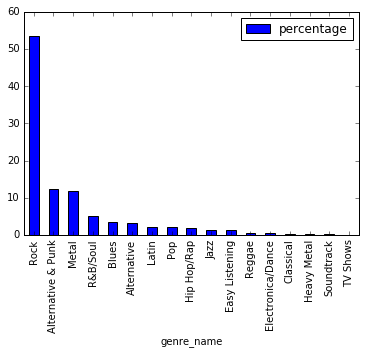

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
genre_sales_usa[['genre_name','percentage']].plot(x='genre_name',kind='bar')

In [19]:
genre_sales_usa['count'].sum()

1051

> ## From the genres totals we can see we want to pick up punk, blues and pop.... Rock is #1

## lets analyze the invoice totals

In [20]:
inv_query='''SELECT
                   sum(i.total) as grand_total_sales
                   FROM
                   invoice i
                   '''
run_query(inv_query)

,grand_total_sales
0,4709.43


In [21]:
sales_query='''WITH emp_sales as (
                   SELECT
                   e.employee_id,
                   sum(i.total) as grand_total_sales
                   FROM
                   employee e
                   INNER JOIN customer c on e.employee_id = c.support_rep_id
                   INNER JOIN invoice i on c.customer_id  = i.customer_id
                   GROUP BY 1
                   )
                   SELECT 
                   e.*,es.grand_total_sales
                   FROM
                   employee e
                   INNER JOIN emp_sales es ON e.employee_id = es.employee_id
                   ORDER BY es.grand_total_sales desc'''
run_query(sales_query)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email,grand_total_sales
0,3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com,1731.51
1,4,Park,Margaret,Sales Support Agent,2,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com,1584.00
2,5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com,1393.92


### Checking about the manager

In [22]:
mgr_query='''SELECT
                   *
                   FROM
                   employee e 
                   WHERE
                   e.title = 'Sales Manager'
                   '''
run_query(mgr_query)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,2,Edwards,Nancy,Sales Manager,1,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com


> ## From what we can see Jane seems to be hired earlier than the rest of reps and is younger than the others

## Analysing per country stats while groups all the singles as other

In [23]:
cntry_query='''WITH country_sales as (
                       SELECT
                           c.country,
                           count(distinct(c.customer_id)) as num_customers,
                           count(i.invoice_id) as num_invoices,
                           sum(i.total) as total_sales
                       FROM
                           customer c 
                           INNER JOIN invoice i on c.customer_id  = i.customer_id
                        GROUP BY 1
                   )
                   select * from country_sales'''
run_query(cntry_query)

,country,num_customers,num_invoices,total_sales
0,Argentina,1,5,39.60
1,Australia,1,10,81.18
2,Austria,1,9,69.30
3,Belgium,1,7,60.39
4,Brazil,5,61,427.68
5,Canada,8,76,535.59
6,Chile,1,13,97.02
7,Czech Republic,2,30,273.24
8,Denmark,1,10,37.62
9,Finland,1,11,79.20


In [24]:
cntry_query='''WITH country_sales as (
                       SELECT
                           c.country,
                           count(distinct(c.customer_id)) as num_customers,
                           count(i.invoice_id) as num_invoices,
                           sum(i.total) as total_sales
                       FROM
                           customer c 
                           INNER JOIN invoice i on c.customer_id  = i.customer_id
                        GROUP BY 1
                   ),
                   ccntry_sales as (
                       SELECT 
                           case when num_customers = 1 then 'Other'
                               else country
                               end as country_name,
                           case when num_customers = 1 then 1
                               else 0
                               end as country_order,
                           num_customers,
                           num_invoices,
                           total_sales
                       FROM
                           country_sales)
                   SELECT
                       country_name,
                       SUM(num_customers) as total_num_customers,
                       SUM(total_sales) as total_sales,
                       round((SUM(total_sales) * 1.0)/SUM(num_customers),2) as average_sales_per_customer,
                       round((SUM(total_sales) * 1.0)/SUM(num_invoices),2) as average_order_val
                   FROM
                       ccntry_sales
                   GROUP BY 1
                   ORDER BY MAX(country_order), SUM(total_sales) desc
                   '''
run_query(cntry_query)

,country_name,total_num_customers,total_sales,average_sales_per_customer,average_order_val
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.57,6.38
8,India,2,183.15,91.57,8.72
9,Other,15,1094.94,73.00,7.45


> ## We can see USA and Canada has the highest sales and we should start expanding in other countries like czech, portugal and india as we can see average sales per customer is high 

## Lets analyze invoices

In [33]:
album_query='''WITH fil_album as (
                       SELECT
                           a.album_id,
                           max(a.title) as album_name,
                           count(t.track_id) as num_tracks
                       FROM
                           album a
                           INNER JOIN track t on a.album_id = t.album_id
                        GROUP BY 1
                        HAVING count(t.track_id) > 2
                        
                   )
                   SELECT * FROM fil_album ORDER BY 3 LIMIT 10
                   '''
run_query(album_query)

,album_id,album_name,num_tracks
0,3,Restless and Wild,3
1,22,Sozinho Remix Ao Vivo,3
2,87,Quanta Gente Veio ver--Bônus De Carnaval,3
3,50,The Final Concerts (Disc 2),4
4,138,The Song Remains The Same (Disc 2),4
5,15,Alcohol Fueled Brewtality Live! [Disc 2],5
6,137,The Song Remains The Same (Disc 1),5
7,44,Physical Graffiti [Disc 1],6
8,198,Santana Live,6
9,249,"The Office, Season 1",6


In [47]:
album_query='''WITH invoices as (
                       SELECT
                           count(invoice_id) as total
                       FROM
                           invoice
                        
                   )
                   SELECT * FROM invoices
                   '''
run_query(album_query)

,total
0,614


In [58]:
album_query='''WITH al_title as (
                       SELECT
                           a.album_id,
                           t.track_id
                       FROM
                           album a
                           INNER JOIN track t on a.album_id = t.album_id
                   ),
                   inv_titles as (
                       SELECT 
                           i.invoice_id,
                           a.album_id,
                           t.track_id
                       FROM 
                           invoice i 
                           INNER JOIN invoice_line il on i.invoice_id = il.invoice_id
                           INNER JOIN track t on il.track_id = t.track_id
                           INNER JOIN album a on t.album_id = a.album_id
                   ),
                   inv_total as (
                       SELECT 
                           i.invoice_id,
                           count(distinct i.album_id) as distinct_albums,
                           count(i.track_id) as number_of_tracks,
                           (SELECT 
                                   it.track_id 
                            FROM 
                                inv_titles it 
                                WHERE it.invoice_id = i.invoice_id

                            EXCEPT

                            SELECT
                                at.track_id 
                            FROM
                                al_title at 
                                WHERE at.album_id IN 
                                    (SELECT album_id
                                     FROM inv_titles it WHERE it.invoice_id  = i.invoice_id)
                            ) is NULL
                            AND
                            (SELECT
                                at.track_id 
                            FROM
                                al_title at 
                                WHERE at.album_id IN 
                                    (SELECT album_id
                                     FROM inv_titles it WHERE it.invoice_id  = i.invoice_id)

                            EXCEPT

                            SELECT 
                                   it.track_id 
                            FROM 
                                inv_titles it 
                                WHERE it.invoice_id = i.invoice_id                    
                            ) is NULL as album_total
                       FROM
                           inv_titles i
                       GROUP BY 1
                       ),
                       fil_invoices as (
                           SELECT 
                            CASE WHEN album_total=1 THEN 'Total_Album_Purchased'
                            ELSE 'Indv_Tracks_Purchased'
                            END as Purchase_Style
                           FROM
                               inv_total
                               WHERE
                               NOT (distinct_albums = 1 AND
                                    number_of_tracks <= 2 AND
                                    album_total = 1)
                        )
                        SELECT
                            Purchase_Style,
                            COUNT(Purchase_Style) AS Num_of_Invoices,
                            ROUND((COUNT(Purchase_Style) * 100.0)/(SELECT COUNT(1) FROM fil_invoices),2)
                              AS Percentage_of_Invoices
                        FROM
                            fil_invoices
                        GROUP BY 1
                   '''
run_query(album_query)

,Purchase_Style,Num_of_Invoices,Percentage_of_Invoices
0,Indv_Tracks_Purchased,500,81.83
1,Total_Album_Purchased,111,18.17


> # We can certainly see that total album purchases are less than 19% and we should not switch to buying popular tracks